
## Introduction

An important special case of machine learning and statistics is *classification*, determining if a dependent variable `y` (or outcome) is in one of two classes.  For simplicity let's call these classes 0 and 1. Even the case measuring the quality of a classification by two valued (again, for simplicity taking values 0 and 1) explanatory variable `x` is of great utility and has extensive theory and practice.

### Confusion matrices

The common summary of performance in the above situation is the confusion matrix (ref: [Wikipedia: Confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix)). To form the confusion matrix we summarize the classifier performance into four counts:


  * True positives (`tp`), the number of times `x = 1` and `y = 1`.
  * False positives (`fp`), the number of times `x = 1` and `y = 0`.
  * True negatives (`tn`), the number of times `x = 0` and `y = 0`.
  * False negatives (`fn`), the number of times `x = 0` and `y = 1`.

These four numbers can be portrayed in convenient table as follows.

<table>
<tr><td></td><td><b>x = 0</b></td><td><b>x = 1</b></td></tr>
<tr><td><b>y = 1</b></td><td>fn</td><td>tp</td></tr>
<tr><td><b>y = 0</b></td><td>tn</td><td>fp</td></tr>
</table>


The confusion matrix is a sufficient statistic for characterizing the relation between two binary or two-valued variables. Many other statistics can be written in terms of its entries. This includes accuracy, sensitivity, specificity, precision, recall, F1, and even AUC (ref: ["A budget of classifier evaluation measures"](https://win-vector.com/2016/07/21/a-budget-of-classifier-evaluation-measures/)).

## A new correspondence score

Sourav Chatterjee introduced a new correspondence score called "xicor" (ref: [xicor](https://arxiv.org/abs/1909.10140)). It measures the ability of one variable to predict another in terms of: does the explanatory variable predict where the dependent variable doesn't vary? This is a change from most measures that directly target if the explanitory variable predicts where the dependent variable does vary.

The general formula is given as:

$\xi(X, Y) := 1 - \frac{n \sum_{i=1}^{n-1} | r_{i+1} - r_{i}|}{2 \sum_{i=1}^{n} l_i (n - l_i)}$

n is just the total number of observations (equal to tp + fp + tn + fn). The $l_i$ and $r_i$ are ranks, the details of which are given both in [the paper](https://arxiv.org/pdf/1909.10140.pdf) and in the [reference R package](https://CRAN.R-project.org/package=XICOR). In particular, the r-s are y-ranks ordered by x, and the l-s are ranks of -y. In both cases "max" tie-breaking is used in computing ranks. xicor is itself a random variable under re-draws of permutations of dat with identical or tied x-values.

## Specializing the new score to confusion matrices

We can specialize xicor to confusion matrices.  To do this we write the expected value of the xicor.

We first observe due to the max tie-breaking in the rank calculations we have:

  * $r_{i}$ is always either tn + fp or n. So $r_{i+1} - r_{i}$ is always either 0 (when y-ranks match) or tp + fn (when the y-ranks do not match).
  * $l_{i}$ is always either n or tp + fn, so n - li is always 0 or tn + fp.

This lets us re-write xicor in this case as.

$\xi(X, Y) = 1 - \frac{n \sum_{i=1}^{n-1} \chi(r_{i+1} == r_{i}) (tp + fn)}{2 (tp + fp) (tp + fp) (tn + fn)}$

All we have done is replaced the denominator with the number of non-zero terms times their value, and introduced an indicator $\chi(r_{i+1} == r_{i})$ defined to be 1 when its argument is true, and 0 otherwise. The details alowing this re-write come from both the paper and the reference R package. The point is, this form is easy to use when computing the expected value over permutations of the x-tied entries.

Now we work out the probability $\chi(r_{i+1} == r_{i}) == 1$ (also the expected value of $\chi(r_{i+1} == r_{i})$). For the examples with x=0, we have tn examples with y=0 and fn examples with y=1. So the ranks match with probability 2 tn fn / (tn + fn)^2. So we can estimate the expected value of each term with x=0, and we just multiply by how many such terms to get their contribution. A similar argument estimate the x=1 terms.

Putting all of this together gives us the following formula for xicor from a confusion matrix. Let's write this down in Python.

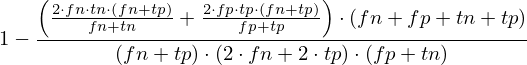

In [1]:
import numpy
import pandas

from sympy import *
init_printing(
    use_latex=True,
    mul_symbol='dot',
    forecolor='Black',
    euler=False)

import seaborn as sns
import matplotlib.pyplot as plt
import xicor.xicor

tp, fp, tn, fn = symbols('tp fp tn fn')
xi_cor_estimate = (
    1 - (tp + fp + tn + fn) * (
        (tn + fn) * (tp + fn) * 2 * tn * fn / (tn + fn)**2
        + (tp + fp) * (tp + fn) * 2 * tp * fp / (tp + fp)**2
    ) / (2 * (tp + fn) * (tn + fp) * (tp + fn))
)

xi_cor_estimate

We can re-arrange terms to get a neater factored form:

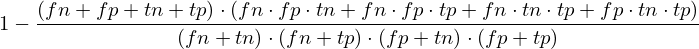

In [2]:
# neater arrangement of the formula

xicor_formula = (
    1 - (fn*fp*tn + fn*fp*tp + fn*tn*tp + fp*tn*tp) * (fn + fp + tn + tp) / ((fn + tn)*(fn + tp)*(fp + tn)*(fp + tp))
)

xicor_formula

In this form we see a lot of structure.

  * `(fn + fp + tn + tp)` is just n, the number of observations.
  * `(fn + tn)*(fn + tp)*(fp + tn)*(fp + tp)` is the product of all rows and columns of the confusion matrix. This denominator means we only get a numeric result when neither x nor y are constants.
  * `(fn*fp*tn + fn*fp*tp + fn*tn*tp + fp*tn*tp)` is all of the leave-1 out products of the confusion matrix entries.

We do have to keep in mind, the formula is only valid where we have not eliminated any terms evaluating to zero.

This is an unusual summary of the confusion matrix. For it appears to be the ratio of two degree 4 polynomials. Most common correspondence scores (such as those mentioned [here](https://win-vector.com/2016/07/21/a-budget-of-classifier-evaluation-measures/)) are ratios of degree 1 or degree 2 polynomials.

Let's confirm this formula is the same form we derived.

In [3]:
# confirm equivalent, should be 0

(xi_cor_estimate - xicor_formula).simplify()


In [4]:
# save latex
print(latex(xicor_formula, mul_symbol='times'))



1 - \frac{\left(fn + fp + tn + tp\right) \times \left(fn \times fp \times tn + fn \times fp \times tp + fn \times tn \times tp + fp \times tn \times tp\right)}{\left(fn + tn\right) \times \left(fn + tp\right) \times \left(fp + tn\right) \times \left(fp + tp\right)}


In [5]:
# wrapr our formula as a function
def xicor_rat_fn(*, tp_c, fp_c, tn_c, fn_c):
    """
    Estimate expected value of xicor using rational function.

    :param tp_c: true positive count
    :param fp_c: false positive count
    :param tn_c: true negative count
    :param fn_c: false negative count
    :return: xicor correlation
    """

    return xicor_formula.subs({tp: tp_c, tn: tn_c, fp: fp_c, fn: fn_c})

We can work some examples. We first compare our rational function to a Python implementation of xicor (note, this implementation is not by the original authors).


In [6]:
# define xicor as a function, so we have something to compare to
def xicor_fn(*, tp_c: int, fp_c: int, tn_c: int, fn_c: int, n_reps=20):
    """
    Define xicor as a function of observed counts.

    :param tp_c: true positive count
    :param fp_c: false positive count
    :param tn_c: true negative count
    :param fn_c: false negative count
    :return: estimated expected xicor correlation
    """
    assert tp_c >= 0
    assert fp_c >= 0
    assert tn_c >= 0
    assert fn_c >= 0
    assert tp_c + fn_c > 0  # y has positive examples
    assert tn_c + fp_c > 0  # y has negative examples
    x = [1] * tp_c + [1] * fp_c + [0] * tn_c + [0] * fn_c
    y = [1] * tp_c + [0] * fp_c + [0] * tn_c + [1] * fn_c
    evals = [xicor.xicor.Xi(x, y).correlation for rep in range(n_reps)]
    return numpy.mean(evals)

In [7]:
# work some examples

float(xicor_rat_fn(tp_c=100, fp_c=10, tn_c=50, fn_c=20))

In [8]:
xicor_fn(tp_c=100, fp_c=10, tn_c=50, fn_c=20)

We can plot some examples confiming the rational funciton agrees with the Python xicor implementation.

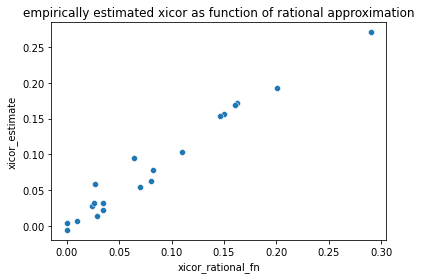

In [9]:
# plot some examples
def mk_ints():
    return numpy.random.choice(100, size=20, replace=True) + 1

examples = pandas.DataFrame({
    'tp_c': mk_ints(),
    'fp_c': mk_ints(),
    'tn_c': mk_ints(),
    'fn_c': mk_ints(),
    'xicor_estimate': 0.0,
    'xicor_rational_fn' : 0.0,
})

for i in range(examples.shape[0]):
    tp_c = examples['tp_c'].values[i]
    fp_c = examples['fp_c'].values[i]
    tn_c = examples['tn_c'].values[i]
    fn_c = examples['fn_c'].values[i]
    examples.loc[i, 'xicor_estimate'] = xicor_fn(tp_c=tp_c, fp_c=fp_c, tn_c=tn_c, fn_c=fn_c)
    examples.loc[i, 'xicor_rational_fn'] = float(xicor_rat_fn(tp_c=tp_c, fp_c=fp_c, tn_c=tn_c, fn_c=fn_c))


ax = sns.scatterplot(data=examples, x='xicor_rational_fn', y='xicor_estimate')
ax.set_title("empirically estimated xicor as function of rational approximation")
plt.show()

Remember, the actual xicor calcultion is computing an expected value of a non-constant random variable. So there is variation in the xicor score, thus no deterministic function can perfectly individual values. However, it is the expected value of xicor that is of interest, not the values of individual data permutations, so the ration function in fact useful and reliable.

We can confirm many symmetries of the rational function.

In [10]:
# check symmetries
a, b, c, d, s = symbols('a b c d s')


In [11]:
# gets independent case right (should equal 0)
xicor_rat_fn(tp_c=s*a, fp_c=s*b, tn_c=b, fn_c=a).simplify()

In [12]:
# gets perfect case right (should be 1)
xicor_rat_fn(tp_c=a, fp_c=0, tn_c=c, fn_c=0).simplify()

In [13]:

# scale invariant (should equal 0)
(
    xicor_rat_fn(tp_c=a, fp_c=b, tn_c=c, fn_c=d)
    - xicor_rat_fn(tp_c=s*a, fp_c=s*b, tn_c=s*c, fn_c=s*d)
).simplify()


In [14]:
# gets flipping y right (should equal 0)
(
    xicor_rat_fn(tp_c=a, fp_c=b, tn_c=c, fn_c=d)
    - xicor_rat_fn(tp_c=b, fp_c=a, tn_c=d, fn_c=c)
).simplify()

In [15]:
# gets flipping x right (should equal 0)
(
    xicor_rat_fn(tp_c=a, fp_c=b, tn_c=c, fn_c=d)
    - xicor_rat_fn(tp_c=c, fp_c=d, tn_c=a, fn_c=b)
).simplify()


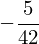

In [16]:
# is asymmetric in x and y (doesn't identically equal 0)
(
    xicor_rat_fn(tp_c=a, fp_c=b, tn_c=c, fn_c=d)
    - xicor_rat_fn(tp_c=a, fp_c=c, tn_c=b, fn_c=d)
).subs({a: 1, b: 2, c: 3, d:4})

It remains to confirm this formula always in the range 0, 1 when the denominator is non-zero and all arguments are non-negative. This is an asymptotic property of the xicor, and should be something we can confirm here with a bit of calculus and algebra.

## Conclusion

The xicor estimator can be specialized to confusion matrices as:

$$1 - \frac{\left(fn + fp + tn + tp\right) \cdot \left(fn \cdot fp \cdot tn + fn \cdot fp \cdot tp + fn \cdot tn \cdot tp + fp \cdot tn \cdot tp\right)}{\left(fn + tn\right) \cdot \left(fn + tp\right) \cdot \left(fp + tn\right) \cdot \left(fp + tp\right)}$$

This form makes a number of the expected symmetries of the expected value of the estimator obvious. It is also possible this is a practical tool in evaluating how well one categorical variable predicts another.